This notebook evaluates the models performance on different levels. This is necessary to see if we can hold the performance or even 
outperform the reconstruction via stitching.

In [11]:
import os 
import sys
sys.path.append('../')
import torchvision.transforms as transforms
import torchvision
import torch

# Import the model definition 
#TODO: Add all models here
from models.definitions.vae import VAE

# Import the dataset
from utils.dataloaders.dataloader_mnist_single import *



In [21]:
# Define transformation
transformations_vae= [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]

# Simple Performance
The performance is meassured for models for different seeds

In [38]:
device = torch.device('mps')
# Load model
model = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(device)
# Load checkpoint
checkpoint = torch.load('../models/checkpoints/VAE/MNIST/MNIST_VAE_3_10.pth', map_location=device)
model.load_state_dict(checkpoint)

# Load data
dataloader = DataLoaderMNIST(128, transformations_vae)
train_loader = dataloader.get_train_loader()
test_loader = dataloader.get_test_loader()






In [40]:
# Average Reconstruction Loss 

def average_reconstruction_loss(model, dataloader):
    model.eval()
    loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            # Reconstruction loss
            loss += model.loss_function(recon_batch, data, mu, logvar).item()
    return loss/ (len(dataloader ) * dataloader.batch_size)

# Print the average reconstruction loss
print("Average Reconstruction Loss: ", average_reconstruction_loss(model, train_loader))



# Show Reconstruction 
import matplotlib.pyplot as plt
import numpy as np

def show_reconstruction(model, dataloader):
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            data = data.to(device)
            recon_batch, _, _ = model(data)
            for j in range(5):
                plt.subplot(2, 5, j+1)
                plt.imshow(data[j].cpu().view(28, 28).numpy(), cmap='gray')
                plt.title('Original')
                plt.subplot(2, 5, j+6)
                plt.imshow(recon_batch[j].cpu().view(28, 28).numpy(), cmap='gray')
                plt.title('Reconstr.')
            plt.show()
            break
#show_reconstruction(model, test_loader)

Average Reconstruction Loss:  108.470461831164


In [42]:
# Performance for each class 

# Get from train loader the class distribution
def get_class_distribution(dataloader):
    class_distribution = {}
    for i, (data, labels) in enumerate(dataloader):
        for j in range(len(labels)):
            label = labels[j].item()
            if label in class_distribution:
                class_distribution[label] += 1
            else:
                class_distribution[label] = 1
    return class_distribution

# Get the class distribution
class_distribution = get_class_distribution(train_loader)

print("Class Distribution: ", class_distribution)

Class Distribution:  {3: 6131, 6: 5918, 0: 5923, 2: 5958, 5: 5421, 8: 5851, 1: 6742, 9: 5949, 7: 6265, 4: 5842}


Loss per class:  {3: 108.53947883149263, 6: 108.52035177217299, 0: 108.53713575778892, 2: 108.75738364428072, 5: 108.65342977552304, 8: 108.68657753826552, 1: 108.00412598154163, 9: 108.44291598778008, 7: 108.44660001421393, 4: 108.47926303010736}


<BarContainer object of 10 artists>

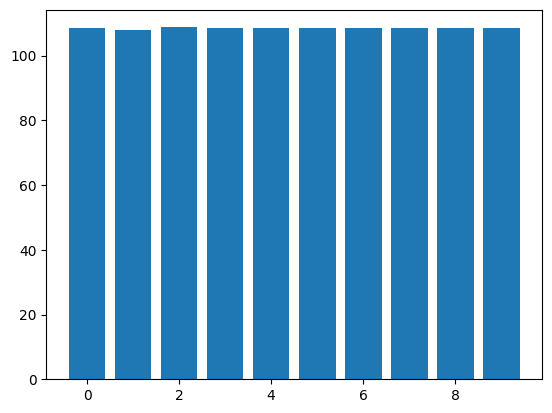

In [49]:
# Get Reconstruction Loss per class
def average_loss_per_class(model, dataloader):
    model.eval()
    class_distribution = get_class_distribution(dataloader)
    loss_per_class = {}
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            # Reconstruction loss
            loss = model.loss_function(recon_batch, data, mu, logvar).item()
            for j in range(len(labels)):
                label = labels[j].item()
                if label in loss_per_class:
                    loss_per_class[label] += loss
                else:
                    loss_per_class[label] = loss
    for key in loss_per_class:
        loss_per_class[key] /= class_distribution[key] * dataloader.batch_size
    print("Loss per class: ", loss_per_class)

    return loss_per_class
average_per_class = average_loss_per_class(model, train_loader)

# Histogram of the reconstruction loss per class
plt.bar(average_per_class.keys(), average_per_class.values())






In [51]:
# Labels with higehst and lowest reconstruction loss

def highest_lowest_reconstruction_loss(model, dataloader):
    model.eval()
    highest_loss = 0
    highest_label = 0
    lowest_loss = 100000
    lowest_label = 0
    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            # Reconstruction loss
            loss = model.loss_function(recon_batch, data, mu, logvar).item()
            for j in range(len(labels)):
                label = labels[j].item()
                if loss > highest_loss:
                    highest_loss = loss
                    highest_label = label
                if loss < lowest_loss:
                    lowest_loss = loss
                    lowest_label = label
    return highest_label, highest_loss, lowest_label, lowest_loss

highest_label, highest_loss, lowest_label, lowest_loss = highest_lowest_reconstruction_loss(model, train_loader)
print("Highest Loss: ", highest_loss, " Label: ", highest_label)

Highest Loss:  15287.771484375  Label:  4
